In [1]:
# importing necessary libraries
import numpy as np
import yfinance as yf # This library is for fetching stock data from yahoo finance
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Fetch historical stock data using yfinance
stock_symbol = 'IBM'
start_date = '2012-01-01'
end_date = '2023-01-01'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)


In [3]:
# Extract adjusted closing prices
prices = stock_data['Adj Close'].values

In [4]:
# Calculate RSI indicator
rsi_period = 14
delta = np.diff(prices)
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
average_gain = np.mean(gain[:rsi_period])
average_loss = np.mean(loss[:rsi_period])
rsi_values = np.zeros_like(prices)
rsi_values[:rsi_period] = 100.0 - (100.0 / (1.0 + (average_gain / average_loss)))

for i in range(rsi_period, len(prices)):
    average_gain = (average_gain * (rsi_period - 1) + gain[i - 1]) / rsi_period
    average_loss = (average_loss * (rsi_period - 1) + loss[i - 1]) / rsi_period
    rsi_values[i] = 100.0 - (100.0 / (1.0 + (average_gain / average_loss)))


In [5]:
# Calculate EMA indicators
emaf_period = 12
emaf_values = np.convolve(prices, np.ones(emaf_period)/emaf_period, mode='valid')
emam_period = 26
emam_values = np.convolve(prices, np.ones(emam_period)/emam_period, mode='valid')
emas_period = 50
emas_values = np.convolve(prices, np.ones(emas_period)/emas_period, mode='valid')


In [6]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))
rsi_scaled = scaler.fit_transform(rsi_values.reshape(-1, 1))
emaf_scaled = scaler.fit_transform(emaf_values.reshape(-1, 1))
emam_scaled = scaler.fit_transform(emam_values.reshape(-1, 1))
emas_scaled = scaler.fit_transform(emas_values.reshape(-1, 1))

In [7]:
# Ensure that all indicator arrays have the same length
common_length = min(len(prices_scaled), len(rsi_scaled), len(emaf_scaled), len(emam_scaled), len(emas_scaled))
prices_scaled = prices_scaled[:common_length]
rsi_scaled = rsi_scaled[:common_length]
emaf_scaled = emaf_scaled[:common_length]
emam_scaled = emam_scaled[:common_length]
emas_scaled = emas_scaled[:common_length]


In [8]:
# Create sequences and labels
sequence_length = 30
X = np.column_stack((prices_scaled, rsi_scaled, emaf_scaled, emam_scaled, emas_scaled))
y = prices_scaled[sequence_length:]
X = [X[i:i + sequence_length] for i in range(len(X) - sequence_length)]
y = [y[i + sequence_length] for i in range(len(y) - sequence_length)]

X = np.array(X)
y = np.array(y)

In [9]:
# Ensure that X and y have the same length
common_length = min(len(X), len(y))
X = X[:common_length]
y = y[:common_length]

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [11]:
# Define the Transformer model architecture
def transformer_model(input_shape, num_layers, d_model, num_heads, d_ff, output_dim):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        x = layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)(x, x)
        x = layers.Dropout(0.2)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(d_ff, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
# Create and compile the model
model = transformer_model(input_shape=(sequence_length, 5), num_layers=6, d_model=64, num_heads=4, d_ff=256, output_dim=1)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 5)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 30, 5)       5893        ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 5)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 30, 5)       10          ['dropout[0][0]']            

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
59/59 [==============================] - 24s 27ms/step - loss: 0.0416 - mse: 0.0416 - mae: 0.1582 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.1307
Epoch 2/100
59/59 [==============================] - 1s 19ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1293 - val_loss: 0.0250 - val_mse: 0.0250 - val_mae: 0.1311
Epoch 3/100
59/59 [==============================] - 1s 20ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1295 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.1304
Epoch 4/100
59/59 [==============================] - 1s 22ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1293 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1280
Epoch 5/100
59/59 [==============================] - 1s 20ms/step - loss: 0.0251 - mse: 0.0251 - mae: 0.1299 - val_loss: 0.0263 - val_mse: 0.0263 - val_mae: 0.1340
Epoch 6/100
59/59 [==============================] - 1s 21ms/step - loss: 0.0246 - mse: 0.0246 - mae: 0.1289 - val_loss: 0.0274 - val_mse: 0.0274 - val_mae: 0.1361
Epoch 7/100
59/

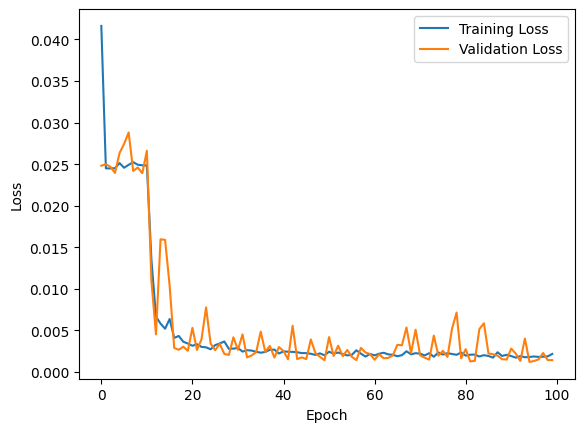

In [15]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)[0]  # Extract the loss value from the list
y_pred = model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))  # Calculate MAE manually

print(f"Test loss: {loss:.4f}, Test MAE: {mae:.4f}")

25/25 [==============================] - 0s 3ms/step
Test loss: 0.0014, Test MAE: 0.0286


In [17]:
# Prediction on the test set

y_pred = model.predict(X_test)

25/25 [==============================] - 0s 4ms/step


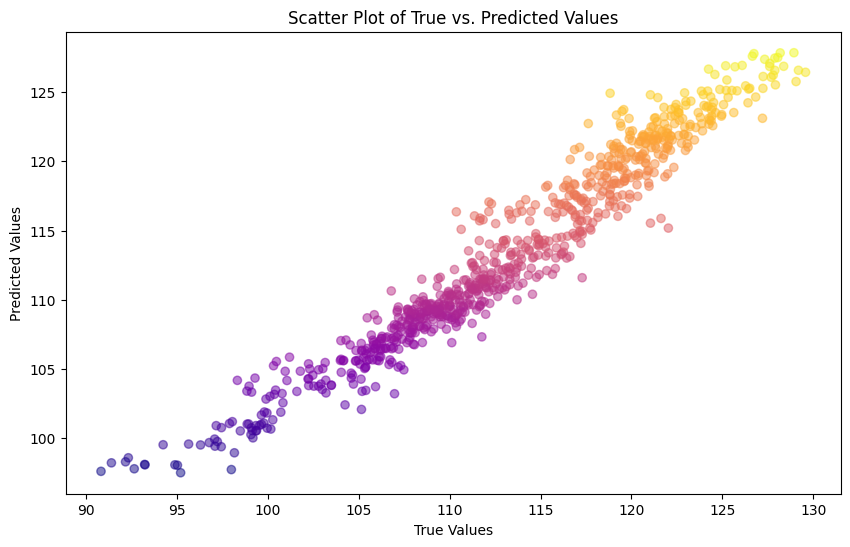

In [18]:

# Inverse scale the predictions and true values
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original,  c= y_pred_original, cmap= 'plasma' , alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.show()

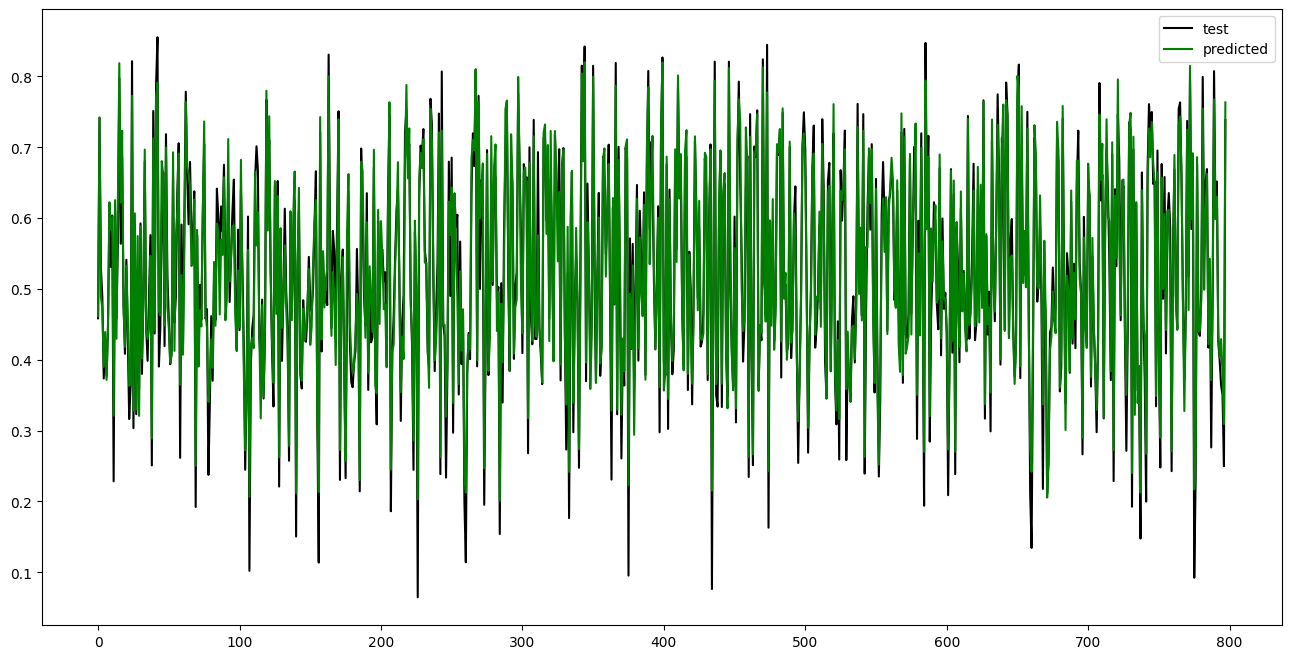

In [19]:
# Line plot for prediction
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black',label='test')
plt.plot(y_pred, color = 'green',label='predicted')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0286
Mean Squared Error (MSE): 0.0014
Root Mean Squared Error (RMSE): 0.0377
R-squared (R2) score: 0.9405


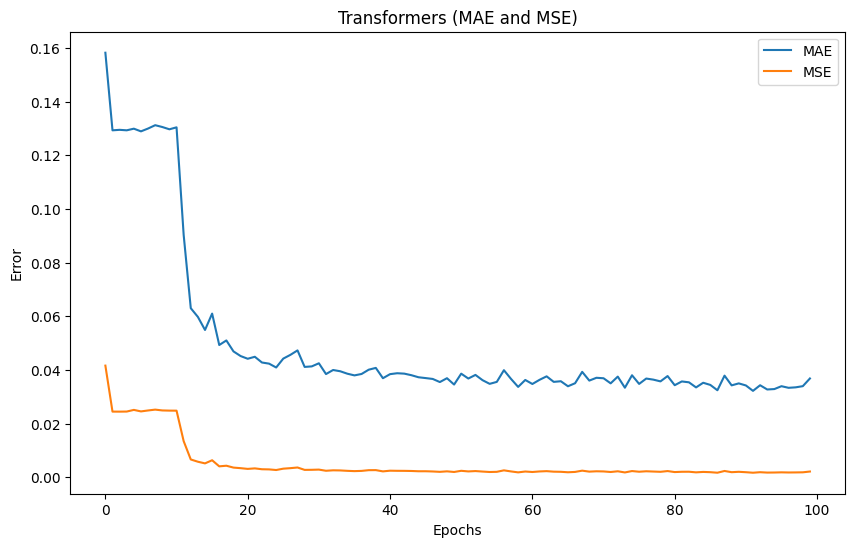

In [21]:
# Line plot over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['mse'], label='MSE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Transformers (MAE and MSE)')
plt.legend()
plt.show()